# 1. 导论

在前面的学习中，我们探讨了一系列简单而实用的回归和分类模型，同时也探讨了如何使用集成学习家族中的Bagging思想去优化最终的模型。Bagging思想的实质是：通过Bootstrap 的方式对全样本数据集进行抽样得到抽样子集，对不同的子集使用同一种基本模型进行拟合，然后投票得出最终的预测。我们也从前面的探讨知道：Bagging主要通过降低方差的方式减少预测误差。那么，本章介绍的Boosting是与Bagging截然不同的思想，Boosting方法是使用同一组数据集进行反复学习，得到一系列简单模型，然后组合这些模型构成一个预测性能十分强大的机器学习模型。显然，Boosting思想提高最终的预测效果是通过不断减少偏差的形式，与Bagging有着本质的不同。在Boosting这一大类方法中，笔者主要介绍两类常用的Boosting方式：Adaptive Boosting 和 Gradient Boosting 以及它们的变体Xgboost、LightGBM以及Catboost。

# 2. Boosting方法的基本思路

在正式介绍Boosting思想之前，我想先介绍两个例子：                   
第一个例子：不知道大家有没有做过错题本，我们将每次测验的错的题目记录在错题本上，不停的翻阅，直到我们完全掌握(也就是能够在考试中能够举一反三)。              
第二个例子：对于一个复杂任务来说，将多个专家的判断进行适当的综合所作出的判断，要比其中任何一个专家单独判断要好。实际上这是一种“三个臭皮匠顶个诸葛亮的道理”。                 
这两个例子都说明Boosting的道理，也就是不错地重复学习达到最终的要求。                
Boosting的提出与发展离不开Valiant和 Kearns的努力，历史上正是Valiant和 Kearns提出了"强可学习"和"弱可学习"的概念。那什么是"强可学习"和"弱可学习"呢？在概率近似正确PAC学习的框架下：            
  - 弱学习：识别错误率小于1/2（即准确率仅比随机猜测略高的学习算法）                     
  - 强学习：识别准确率很高并能在多项式时间内完成的学习算法                                   

非常有趣的是，在PAC 学习的框架下，强可学习和弱可学习是等价的，也就是说一个概念是强可学习的充分必要条件是这个概念是弱可学习的。这样一来，问题便是：在学习中，如果已经发现了弱可学习算法，能否将他提升至强可学习算法。因为，弱可学习算法比强可学习算法容易得多。提升方法就是从弱学习算法出发，反复学习，得到一系列弱分类器(又称为基本分类器)，然后通过一定的形式去组合这些弱分类器构成一个强分类器。大多数的Boosting方法都是通过改变训练数据集的概率分布(训练数据不同样本的权值)，针对不同概率分布的数据调用弱分类算法学习一系列的弱分类器。              
对于Boosting方法来说，有两个问题需要给出答案：第一个是每一轮学习应该如何改变数据的概率分布，第二个是如何将各个弱分类器组合起来。关于这两个问题，不同的Boosting算法会有不同的答案，我们接下来介绍一种最经典的Boosting算法----Adaboost，我们需要理解Adaboost是怎么处理这两个问题以及为什么这么处理的。

# 3. Adaboost算法

**Adaboost的基本原理**                             

对于Adaboost来说，解决上述的两个问题的方式是：1. 提高那些被前一轮分类器错误分类的样本的权重，而降低那些被正确分类的样本的权重。这样一来，那些在上一轮分类器中没有得到正确分类的样本，由于其权重的增大而在后一轮的训练中“备受关注”。2. 各个弱分类器的组合是通过采取加权多数表决的方式，具体来说，加大分类错误率低的弱分类器的权重，因为这些分类器能更好地完成分类任务，而减小分类错误率较大的弱分类器的权重，使其在表决中起较小的作用。                          
现在，我们来具体介绍Adaboost算法：(参考李航老师的《统计学习方法》)                       
假设给定一个二分类的训练数据集：$T=\left\{\left(x_{1}, y_{1}\right),\left(x_{2}, y_{2}\right), \cdots,\left(x_{N}, y_{N}\right)\right\}$，其中每个样本点由特征与类别组成。特征$x_{i} \in \mathcal{X} \subseteq \mathbf{R}^{n}$，类别$y_{i} \in \mathcal{Y}=\{-1,+1\}$，$\mathcal{X}$是特征空间，$ \mathcal{Y}$是类别集合，输出最终分类器$G(x)$。Adaboost算法如下：                 
(1) 初始化训练数据的分布：$D_{1}=\left(w_{11}, \cdots, w_{1 i}, \cdots, w_{1 N}\right), \quad w_{1 i}=\frac{1}{N}, \quad i=1,2, \cdots, N$                       
(2) 对于m=1,2,...,M            
   - 使用具有权值分布$D_m$的训练数据集进行学习，得到基本分类器：$G_{m}(x): \mathcal{X} \rightarrow\{-1,+1\}$                  
   - 计算$G_m(x)$在训练集上的分类误差率$e_{m}=\sum_{i=1}^{N} P\left(G_{m}\left(x_{i}\right) \neq y_{i}\right)=\sum_{i=1}^{N} w_{m i} I\left(G_{m}\left(x_{i}\right) \neq y_{i}\right)$                   
   - 计算$G_m(x)$的系数$\alpha_{m}=\frac{1}{2} \log \frac{1-e_{m}}{e_{m}}$，这里的log是自然对数ln                         
   - 更新训练数据集的权重分布                
   $$
   \begin{array}{c}
   D_{m+1}=\left(w_{m+1,1}, \cdots, w_{m+1, i}, \cdots, w_{m+1, N}\right) \\
   w_{m+1, i}=\frac{w_{m i}}{Z_{m}} \exp \left(-\alpha_{m} y_{i} G_{m}\left(x_{i}\right)\right), \quad i=1,2, \cdots, N
   \end{array}
   $$                       
   这里的$Z_m$是规范化因子，使得$D_{m+1}$称为概率分布，$Z_{m}=\sum_{i=1}^{N} w_{m i} \exp \left(-\alpha_{m} y_{i} G_{m}\left(x_{i}\right)\right)$                          

(3) 构建基本分类器的线性组合$f(x)=\sum_{m=1}^{M} \alpha_{m} G_{m}(x)$，得到最终的分类器                       

$$
\begin{aligned}
G(x) &=\operatorname{sign}(f(x)) \\
&=\operatorname{sign}\left(\sum_{m=1}^{M} \alpha_{m} G_{m}(x)\right)
\end{aligned}
$$                          

下面对Adaboost算法做如下说明：                                            
对于步骤(1)，假设训练数据的权值分布是均匀分布，是为了使得第一次没有先验信息的条件下每个样本在基本分类器的学习中作用一样。                         
对于步骤(2)，每一次迭代产生的基本分类器$G_m(x)$在加权训练数据集上的分类错误率$\begin{aligned}e_{m} &=\sum_{i=1}^{N} P\left(G_{m}\left(x_{i}\right) \neq y_{i}\right) =\sum_{G_{m}\left(x_{i}\right) \neq y_{i}} w_{m i}\end{aligned}$代表了在$G_m(x)$中分类错误的样本权重和，这点直接说明了权重分布$D_m$与$G_m(x)$的分类错误率$e_m$有直接关系。同时，在步骤(2)中，计算基本分类器$G_m(x)$的系数$\alpha_m$，$\alpha_{m}=\frac{1}{2} \log \frac{1-e_{m}}{e_{m}}$，它表示了$G_m(x)$在最终分类器的重要性程度，$\alpha_m$的取值由基本分类器$G_m(x)$的分类错误率有直接关系，当$e_{m} \leqslant \frac{1}{2}$时，$\alpha_{m} \geqslant 0$，并且$\alpha_m$随着$e_m$的减少而增大，因此分类错误率越小的基本分类器在最终分类器的作用越大！                       
**最重要的，对于步骤(2)中的样本权重的更新：  **                                    
$$
w_{m+1, i}=\left\{\begin{array}{ll}
\frac{w_{m i}}{Z_{m}} \mathrm{e}^{-\alpha_{m}}, & G_{m}\left(x_{i}\right)=y_{i} \\
\frac{w_{m i}}{Z_{m}} \mathrm{e}^{\alpha_{m}}, & G_{m}\left(x_{i}\right) \neq y_{i}
\end{array}\right.
$$                        
因此，从上式可以看到：被基本分类器$G_m(x)$错误分类的样本的权重扩大，被正确分类的样本权重减少，二者相比相差$\mathrm{e}^{2 \alpha_{m}}=\frac{1-e_{m}}{e_{m}}$倍。                             
对于步骤(3)，线性组合$f(x)$实现了将M个基本分类器的加权表决，系数$\alpha_m$标志了基本分类器$G_m(x)$的重要性，值得注意的是：所有的$\alpha_m$之和不为1。$f(x)$的符号决定了样本x属于哪一类。             

下面，我们使用一组简单的数据来手动计算Adaboost算法的过程：(例子来源：http://www.csie.edu.tw)                                                               

训练数据如下表，假设基本分类器的形式是一个分割$x<v$或$x>v$表示，阈值v由该基本分类器在训练数据集上分类错误率$e_m$最低确定。                                                
$$
\begin{array}{ccccccccccc}
\hline \text { 序号 } & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\
\hline x & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \\
y & 1 & 1 & 1 & -1 & -1 & -1 & 1 & 1 & 1 & -1 \\
\hline
\end{array}
$$                                          
解：                        
初始化样本权值分布
$$
\begin{aligned}
D_{1} &=\left(w_{11}, w_{12}, \cdots, w_{110}\right) \\
w_{1 i} &=0.1, \quad i=1,2, \cdots, 10
\end{aligned}
$$                                  
对m=1:                      
   - 在权值分布$D_1$的训练数据集上，遍历每个结点并计算分类误差率$e_m$，阈值取v=2.5时分类误差率最低，那么基本分类器为：
   $$
   G_{1}(x)=\left\{\begin{array}{ll}
   1, & x<2.5 \\
   -1, & x>2.5
   \end{array}\right.
   $$                         
   - $G_1(x)$在训练数据集上的误差率为$e_{1}=P\left(G_{1}\left(x_{i}\right) \neq y_{i}\right)=0.3$。                                           
   - 计算$G_1(x)$的系数：$\alpha_{1}=\frac{1}{2} \log \frac{1-e_{1}}{e_{1}}=0.4236$               
   - 更新训练数据的权值分布：                  
   $$
   \begin{aligned}
   D_{2}=&\left(w_{21}, \cdots, w_{2 i}, \cdots, w_{210}\right) \\
   w_{2 i}=& \frac{w_{1 i}}{Z_{1}} \exp \left(-\alpha_{1} y_{i} G_{1}\left(x_{i}\right)\right), \quad i=1,2, \cdots, 10 \\
   D_{2}=&(0.07143,0.07143,0.07143,0.07143,0.07143,0.07143,\\
   &0.16667,0.16667,0.16667,0.07143) \\
   f_{1}(x) &=0.4236 G_{1}(x)
   \end{aligned}
   $$

对于m=2：                   
   - 在权值分布$D_2$的训练数据集上，遍历每个结点并计算分类误差率$e_m$，阈值取v=8.5时分类误差率最低，那么基本分类器为：                  
   $$
   G_{2}(x)=\left\{\begin{array}{ll}
   1, & x<8.5 \\
   -1, & x>8.5
   \end{array}\right.
   $$                       
   - $G_2(x)$在训练数据集上的误差率为$e_2 = 0.2143$                    
   - 计算$G_2(x)$的系数：$\alpha_2 = 0.6496$                        
   - 更新训练数据的权值分布：                  
   $$
   \begin{aligned}
   D_{3}=&(0.0455,0.0455,0.0455,0.1667,0.1667,0.1667\\
   &0.1060,0.1060,0.1060,0.0455) \\
   f_{2}(x) &=0.4236 G_{1}(x)+0.6496 G_{2}(x)
   \end{aligned}
   $$                   
   
对m=3：                          
   - 在权值分布$D_3$的训练数据集上，遍历每个结点并计算分类误差率$e_m$，阈值取v=5.5时分类误差率最低，那么基本分类器为：                     
   $$
   G_{3}(x)=\left\{\begin{array}{ll}
   1, & x>5.5 \\
   -1, & x<5.5
   \end{array}\right.
   $$                               
   - $G_3(x)$在训练数据集上的误差率为$e_3 = 0.1820$                       
   - 计算$G_3(x)$的系数：$\alpha_3 = 0.7514$                                 
   - 更新训练数据的权值分布：                    
   $$
   D_{4}=(0.125,0.125,0.125,0.102,0.102,0.102,0.065,0.065,0.065,0.125)
   $$                       
   
于是得到：$f_{3}(x)=0.4236 G_{1}(x)+0.6496 G_{2}(x)+0.7514 G_{3}(x)$，分类器$\operatorname{sign}\left[f_{3}(x)\right]$在训练数据集上的误分类点的个数为0。                                
于是得到最终分类器为：$G(x)=\operatorname{sign}\left[f_{3}(x)\right]=\operatorname{sign}\left[0.4236 G_{1}(x)+0.6496 G_{2}(x)+0.7514 G_{3}(x)\right]$

**下面，我们使用sklearn对Adaboost算法进行建模：**

本次案例我们使用一份UCI的机器学习库里的开源数据集：葡萄酒数据集，该数据集可以在 ( https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data )上获得。该数据集包含了178个样本和13个特征，从不同的角度对不同的化学特性进行描述，我们的任务是根据这些数据预测红酒属于哪一个类别。(案例来源《python机器学习(第二版》)

In [1]:
# 引入数据科学相关工具包：
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

In [2]:
# 加载训练数据：         
wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data",header=None)
wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols','Flavanoids', 'Nonflavanoid phenols', 
                'Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']

In [3]:
# 数据查看：
print("Class labels",np.unique(wine["Class label"]))
wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


下面对数据做简单解读：                    
   - Class label：分类标签         
   - Alcohol：酒精                   
   - Malic acid：苹果酸                      
   - Ash：灰                  
   - Alcalinity of ash：灰的碱度                  
   - Magnesium：镁                     
   - Total phenols：总酚                      
   - Flavanoids：黄酮类化合物                      
   - Nonflavanoid phenols：非黄烷类酚类                      
   - Proanthocyanins：原花青素                     
   - Color intensity：色彩强度                 
   - Hue：色调                       
   - OD280/OD315 of diluted wines：稀释酒OD280 OD350                      
   - Proline：脯氨酸                 

In [4]:
# 数据预处理
# 仅仅考虑2，3类葡萄酒，去除1类
wine = wine[wine['Class label'] != 1]
y = wine['Class label'].values
X = wine[['Alcohol','OD280/OD315 of diluted wines']].values

# 将分类标签变成二进制编码：
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# 按8：2分割训练集和测试集
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)  # stratify参数代表了按照y的类别等比例抽样

In [5]:
# 使用单一决策树建模
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=1)
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train,tree_test))

Decision tree train/test accuracies 0.916/0.875


In [6]:
# 使用sklearn实现Adaboost(基分类器为决策树)
'''
AdaBoostClassifier相关参数：
base_estimator：基本分类器，默认为DecisionTreeClassifier(max_depth=1)
n_estimators：终止迭代的次数
learning_rate：学习率
algorithm：训练的相关算法，{'SAMME'，'SAMME.R'}，默认='SAMME.R'
random_state：随机种子
'''
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)
ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print('Adaboost train/test accuracies %.3f/%.3f' % (ada_train,ada_test))

Adaboost train/test accuracies 1.000/0.917


结果分析：单层决策树似乎对训练数据欠拟合，而Adaboost模型正确地预测了训练数据的所有分类标签，而且与单层决策树相比，Adaboost的测试性能也略有提高。然而，为什么模型在训练集和测试集的性能相差这么大呢？我们使用图像来简单说明下这个道理！

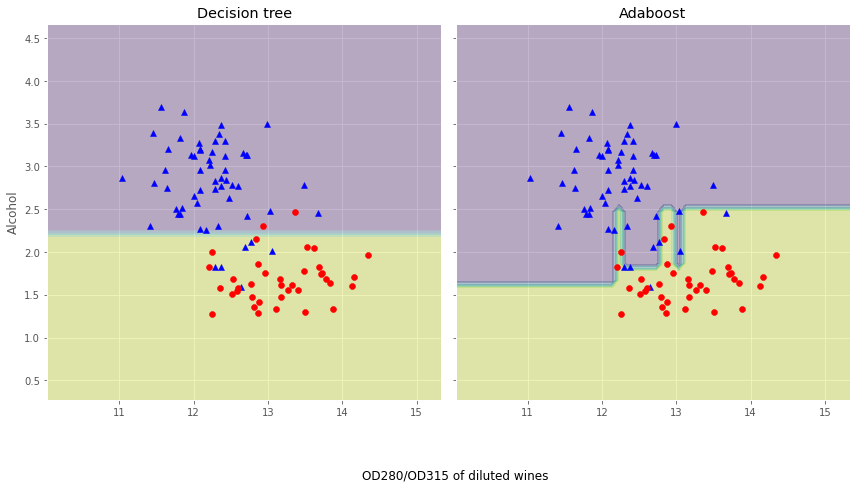

In [7]:
# 画出单层决策树与Adaboost的决策边界：
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,sharex='col',sharey='row',figsize=(12, 6))
for idx, clf, tt in zip([0, 1],[tree, ada],['Decision tree', 'Adaboost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],X_train[y_train==0, 1],c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],X_train[y_train==1, 1],c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,s='OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12,transform=axarr[1].transAxes)
plt.show()

从上面的决策边界图可以看到：Adaboost模型的决策边界比单层决策树的决策边界要复杂的多。也就是说，Adaboost试图用增加模型复杂度而降低偏差的方式去减少总误差，但是过程中引入了方差，可能出现国拟合，因此在训练集和测试集之间的性能存在较大的差距，这就简单地回答的刚刚问题。值的注意的是：与单个分类器相比，Adaboost等Boosting模型增加了计算的复杂度，在实践中需要仔细思考是否愿意为预测性能的相对改善而增加计算成本，而且Boosting方式无法做到现在流行的并行计算的方式进行训练，因为每一步迭代都要基于上一部的基本分类器。